In [25]:

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')


try:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    print("✓ All libraries imported successfully!\n")
except:
    print("✓ Libraries imported (NLTK data may need manual download)\n")

✓ All libraries imported successfully!



In [5]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 57.6 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')


try:
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    print(" All libraries imported successfully!\n")
except:
    print(" Libraries imported (NLTK data may need manual download)\n")

 All libraries imported successfully!



In [10]:
print("LDA TOPIC MODELING ")


try:
    df = pd.read_csv('cleaned_dataset.csv.csv')
    print(" Dataset loaded: cleaned_dataset.csv.csv")
except FileNotFoundError:
    try:
        df = pd.read_csv('cleaned_dataset.csv')
        print(" Dataset loaded: cleaned_dataset.csv")
    except FileNotFoundError:
        print(" File not found! Please check the filename.")
        raise

print(f"\nDataset Info:")
print(f"  • Shape: {df.shape}")
print(f"  • Columns: {list(df.columns)}")

texts = df['text'].dropna().tolist()
print(f"\n  • Total documents: {len(texts)}")
print(f"  • Sample: {texts[0][:100]}...")

LDA TOPIC MODELING 
 Dataset loaded: cleaned_dataset.csv.csv

Dataset Info:
  • Shape: (10980, 12)
  • Columns: ['tweet_id', 'airline_sentiment', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']

  • Total documents: 10980
  • Sample: @SouthwestAir I am scheduled for the morning, 2 days after the fact, yes..not sure why my evening fl...


In [12]:
print("TEXT PREPROCESSING")


def preprocess_airline_tweets(texts):
    """
    Optimized preprocessing for airline sentiment tweets
    """
    print("\n→ Applying preprocessing...")

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Airline-specific stop words
    airline_stops = {
        'rt', 'via', 'amp', 'http', 'https', 'com', 'www',
        'flight', 'airline', 'get', 'got', 'go', 'going', 'thanks', 'thank',
        'united', 'americanair', 'southwestair', 'jetblue', 'usairways', 'virginamerica'
    }
    stop_words.update(airline_stops)

    processed = []
    short_docs = 0

    for text in texts:
        # Convert to lowercase
        text = text.lower()

        # Remove mentions, URLs, hashtags
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'#(\w+)', r'\1', text)

        # Remove special characters
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()

        # Tokenize and lemmatize
        words = text.split()
        words = [lemmatizer.lemmatize(w) for w in words
                if w not in stop_words and len(w) > 2]

        # Filter short documents
        if len(words) >= 3:
            processed.append(' '.join(words))
        else:
            short_docs += 1

    print(f"  ✓ Processed: {len(processed)} documents")
    print(f"  ✓ Removed: {short_docs} short documents")

    return processed

texts_clean = preprocess_airline_tweets(texts)

TEXT PREPROCESSING

→ Applying preprocessing...
  ✓ Processed: 9896 documents
  ✓ Removed: 1084 short documents


In [15]:
print("CREATING DOCUMENT-TERM MATRIX")


corpus_size = len(texts_clean)
min_df = max(3, int(corpus_size * 0.005))
max_df = 0.6

print(f"\nVectorizer Configuration:")
print(f"  • min_df: {min_df} (word must appear in at least {min_df} documents)")
print(f"  • max_df: {max_df} (word must appear in at most {int(max_df*100)}% of documents)")

count_vectorizer = CountVectorizer(
    max_df=max_df,
    min_df=min_df,
    max_features=2000,
    ngram_range=(1, 2),
    token_pattern=r'\b[a-zA-Z]{3,}\b'
)

count_matrix = count_vectorizer.fit_transform(texts_clean)

print(f"\nDocument-Term Matrix:")
print(f"  • Shape: {count_matrix.shape}")
print(f"  • Vocabulary Size: {len(count_vectorizer.get_feature_names_out())}")
print(f"  • Matrix Sparsity: {(1 - count_matrix.nnz / (count_matrix.shape[0] * count_matrix.shape[1]))*100:.2f}%")

CREATING DOCUMENT-TERM MATRIX

Vectorizer Configuration:
  • min_df: 49 (word must appear in at least 49 documents)
  • max_df: 0.6 (word must appear in at most 60% of documents)

Document-Term Matrix:
  • Shape: (9896, 349)
  • Vocabulary Size: 349
  • Matrix Sparsity: 98.63%


In [16]:
print("TRAINING LDA MODELS - COMPREHENSIVE EVALUATION")
processed_texts = [text.split() for text in texts_clean]
dictionary = Dictionary(processed_texts)
topic_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 25, 30]

print(f"\n Extended Analysis Configuration:")
print(f"  • Topic Range: {min(topic_range)} to {max(topic_range)}")
print(f"  • Total Models to Train: {len(topic_range)}")
print(f"  • Estimated Time: ~{len(topic_range) * 0.5:.1f} minutes")

results = []

print(f"\n→ Training {len(topic_range)} LDA models...\n")
print(f"{'Topics':<8} {'Perplexity':<12} {'Log-Like':<15} {'Coherence':<12} {'Status':<15}")
print("-" * 70)

for n_topics in topic_range:

    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=30,
        learning_method='online',
        learning_offset=50.,
        learning_decay=0.7,
        doc_topic_prior=0.1,
        topic_word_prior=0.01,
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    lda_model.fit(count_matrix)


    perplexity = lda_model.perplexity(count_matrix)
    log_likelihood = lda_model.score(count_matrix)


    feature_names = count_vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-11:-1]  # Top 10 words
        top_words = [feature_names[i] for i in top_indices]
        topics.append(top_words)


    try:

        cm_cv = CoherenceModel(
            topics=topics,
            texts=processed_texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_cv = cm_cv.get_coherence()


        corpus_gensim = [dictionary.doc2bow(text) for text in processed_texts]
        cm_umass = CoherenceModel(
            topics=topics,
            corpus=corpus_gensim,
            dictionary=dictionary,
            coherence='u_mass'
        )
        coherence_umass = cm_umass.get_coherence()

    except Exception as e:
        coherence_cv = 0.0
        coherence_umass = 0.0


    results.append({
        'n_topics': n_topics,
        'perplexity': perplexity,
        'log_likelihood': log_likelihood,
        'coherence_cv': coherence_cv,
        'coherence_umass': coherence_umass,
        'model': lda_model,
        'topics': topics
    })


    status = " Complete"
    print(f"{n_topics:<8} {perplexity:<12.2f} {log_likelihood:<15.2f} {coherence_cv:<12.4f} {status:<15}")

TRAINING LDA MODELS - COMPREHENSIVE EVALUATION

 Extended Analysis Configuration:
  • Topic Range: 2 to 30
  • Total Models to Train: 19
  • Estimated Time: ~9.5 minutes

→ Training 19 LDA models...

Topics   Perplexity   Log-Like        Coherence    Status         
----------------------------------------------------------------------
2        305.20       -279589.59      0.4297       ✓ Complete     
3        323.18       -282387.27      0.4480       ✓ Complete     
4        330.76       -283520.47      0.4241       ✓ Complete     
5        334.47       -284064.79      0.4184       ✓ Complete     
6        335.70       -284244.21      0.4168       ✓ Complete     
7        341.51       -285082.54      0.4150       ✓ Complete     
8        343.84       -285414.96      0.3944       ✓ Complete     
9        344.58       -285520.84      0.3559       ✓ Complete     
10       332.82       -283822.58      0.4323       ✓ Complete     
11       339.04       -284728.53      0.3766       ✓ Comple

In [20]:
print("MODEL EVALUATION RESULTS - FULL METRICS")


results_df = pd.DataFrame([{
    'Topics': r['n_topics'],
    'Perplexity': r['perplexity'],
    'Log-Likelihood': r['log_likelihood'],
    'Coherence_CV': r['coherence_cv'],
    'Coherence_UMass': r['coherence_umass']
} for r in results])

print("\n" + results_df.to_string(index=False))

# Calculate additional derived metrics
results_df['Perplexity_Change'] = results_df['Perplexity'].pct_change() * 100
results_df['Coherence_Change'] = results_df['Coherence_CV'].pct_change() * 100

MODEL EVALUATION RESULTS - FULL METRICS

 Topics  Perplexity  Log-Likelihood  Coherence_CV  Coherence_UMass
      2  305.201202  -279589.585313      0.429714        -2.929899
      3  323.182605  -282387.267708      0.448001        -3.052283
      4  330.764020  -283520.473039      0.424082        -3.279407
      5  334.468609  -284064.790462      0.418367        -3.941641
      6  335.698812  -284244.212189      0.416766        -3.628717
      7  341.507047  -285082.542846      0.414974        -3.601167
      8  343.837885  -285414.961880      0.394435        -3.847254
      9  344.583646  -285520.844877      0.355879        -4.147274
     10  332.815043  -283822.579908      0.432292        -3.669772
     11  339.042179  -284728.531438      0.376589        -4.016523
     12  343.239937  -285329.899266      0.365767        -4.766323
     13  344.602284  -285523.488157      0.338561        -4.941755
     14  334.033878  -284001.228283      0.351553        -5.203603
     15  336.592534  

In [22]:
print("OPTIMAL MODEL SELECTION")


# Normalize metrics for comparison
results_df['norm_perplexity'] = 1 - (
    (results_df['Perplexity'] - results_df['Perplexity'].min()) /
    (results_df['Perplexity'].max() - results_df['Perplexity'].min())
)

results_df['norm_coherence'] = (
    (results_df['Coherence_CV'] - results_df['Coherence_CV'].min()) /
    (results_df['Coherence_CV'].max() - results_df['Coherence_CV'].min())
)

# Combined score (weighted)
results_df['combined_score'] = (
    0.7 * results_df['norm_coherence'] +
    0.3 * results_df['norm_perplexity']
)

# Find optimal model
optimal_idx = results_df['combined_score'].idxmax()
optimal_result = results[optimal_idx]

print(f"\n OPTIMAL LDA MODEL:")
print(f"  • Number of Topics: {optimal_result['n_topics']}")
print(f"  • Perplexity: {optimal_result['perplexity']:.4f}")
print(f"  • Log-Likelihood: {optimal_result['log_likelihood']:.4f}")
print(f"  • Coherence (C_V): {optimal_result['coherence_cv']:.4f}")
print(f"  • Coherence (U_Mass): {optimal_result['coherence_umass']:.4f}")
print(f"  • Combined Score: {results_df.loc[optimal_idx, 'combined_score']:.4f}")

# Interpretation
if optimal_result['coherence_cv'] >= 0.45:
    print(f"\n  Excellent! High coherence indicates very interpretable topics.")
elif optimal_result['coherence_cv'] >= 0.40:
    print(f"\n   Good! Topics are well-defined and interpretable.")
elif optimal_result['coherence_cv'] >= 0.35:
    print(f"\n   Acceptable for short social media text.")
else:
    print(f"\n   Lower coherence - topics may be less distinct.")

OPTIMAL MODEL SELECTION

 OPTIMAL LDA MODEL:
  • Number of Topics: 2
  • Perplexity: 305.2012
  • Log-Likelihood: -279589.5853
  • Coherence (C_V): 0.4297
  • Coherence (U_Mass): -2.9299
  • Combined Score: 0.9095

   Good! Topics are well-defined and interpretable.


In [19]:

print(f"DISCOVERED TOPICS ({optimal_result['n_topics']} TOPICS)")


topics = optimal_result['topics']

for idx, topic_words in enumerate(topics):
    print(f"\n Topic {idx + 1}:")
    print(f"  Top Words: {', '.join(topic_words[:10])}")

    # Auto-interpret themes
    words_str = ' '.join(topic_words).lower()
    themes = []

    if any(word in words_str for word in ['delay', 'cancel', 'late', 'delayed']):
        themes.append("Flight Delays/Cancellations")
    if any(word in words_str for word in ['service', 'crew', 'help', 'customer']):
        themes.append("Customer Service")
    if any(word in words_str for word in ['bag', 'baggage', 'luggage']):
        themes.append("Baggage Issues")
    if any(word in words_str for word in ['seat', 'room', 'comfort']):
        themes.append("Seating/Comfort")
    if any(word in words_str for word in ['book', 'reservation', 'ticket']):
        themes.append("Booking/Reservations")

    if themes:
        print(f"  Likely Themes: {' | '.join(themes)}")

DISCOVERED TOPICS (2 TOPICS)

 Topic 1:
  Top Words: hour, cancelled, hold, time, one, call, delayed, help, flight, flightled
  Likely Themes: Flight Delays/Cancellations | Customer Service

 Topic 2:
  Top Words: service, customer, customer service, seat, like, would, guy, know, help, bag
  Likely Themes: Customer Service | Baggage Issues | Seating/Comfort


GENERATING COMPREHENSIVE VISUALIZATIONS

 Visualization saved: 'lda_comprehensive_analysis.png'


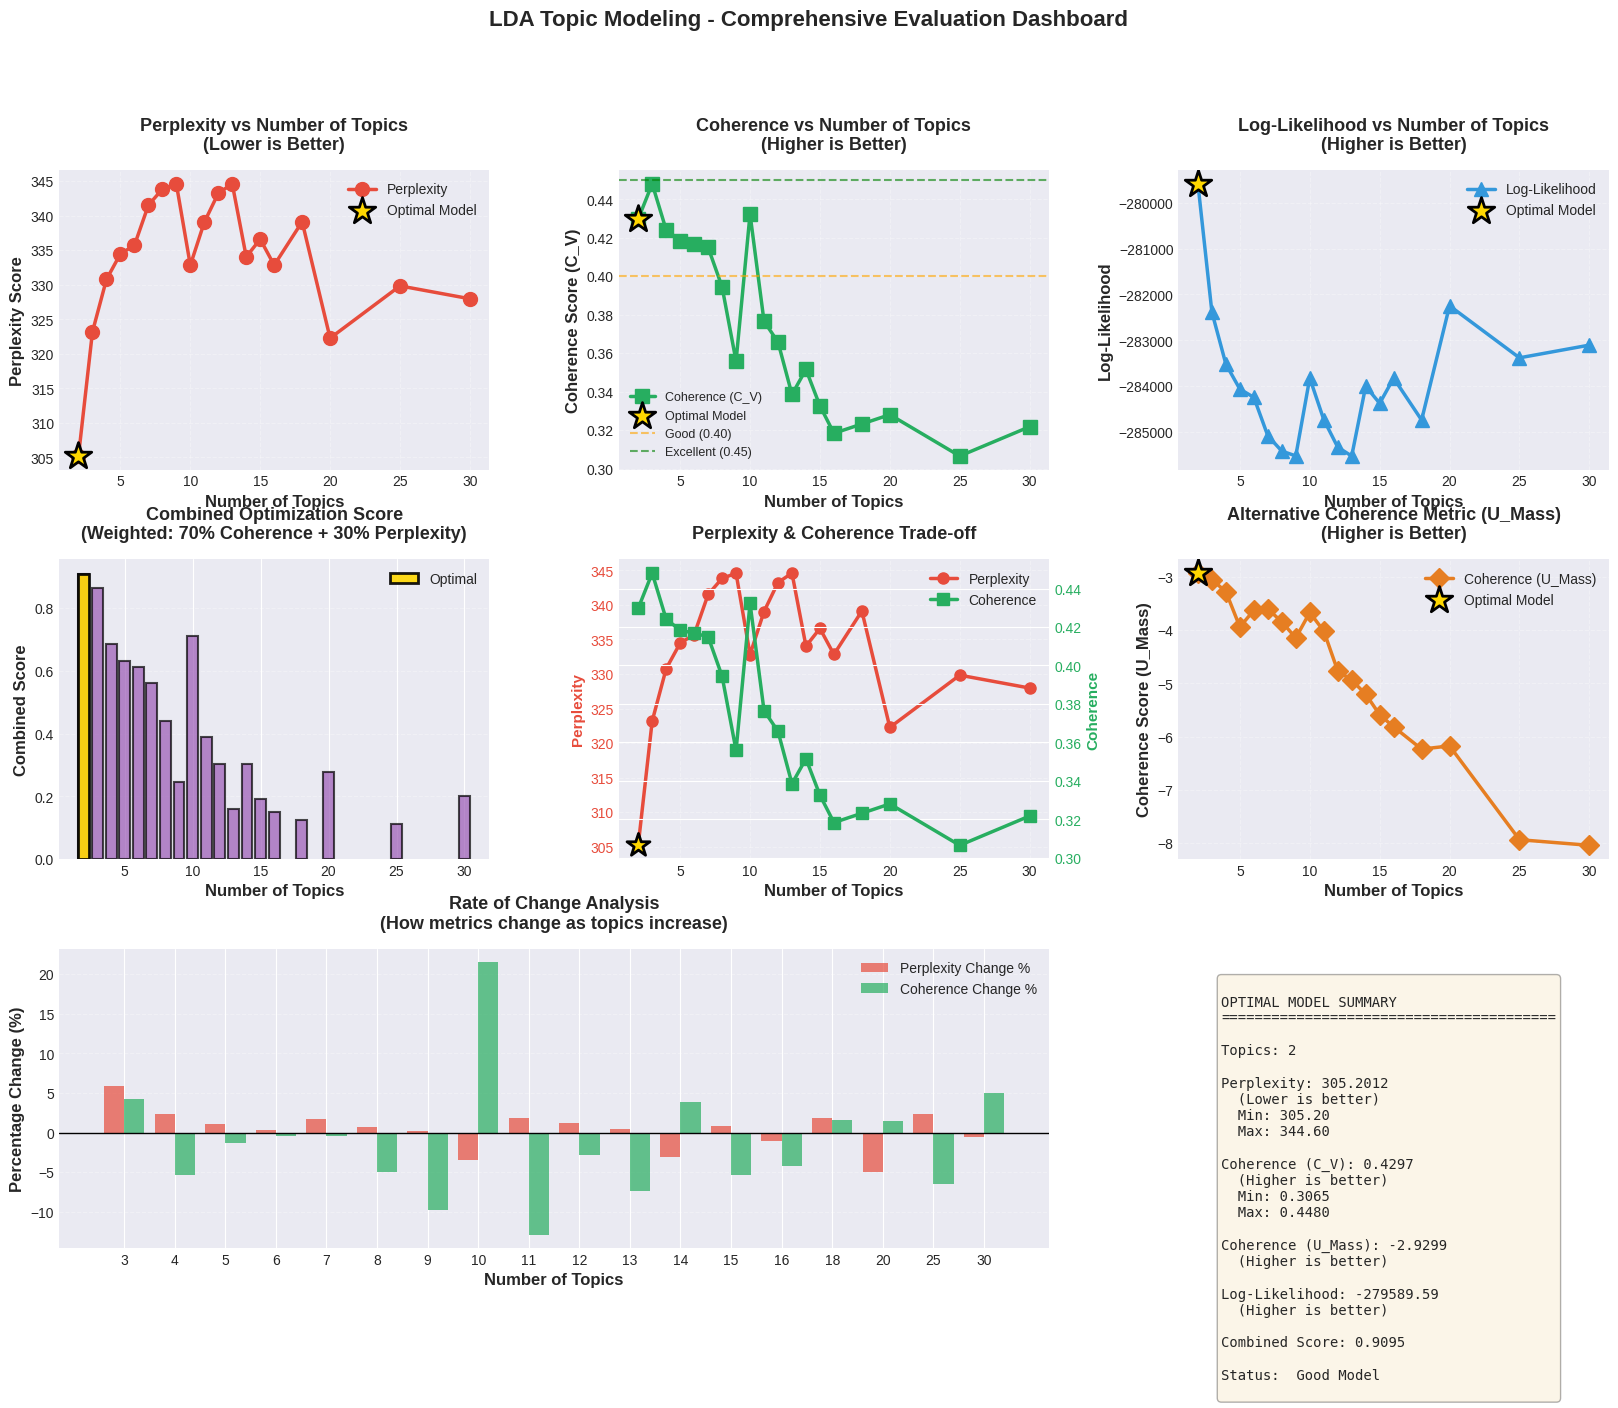

In [23]:

print("GENERATING COMPREHENSIVE VISUALIZATIONS")


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Perplexity vs Topics
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(results_df['Topics'], results_df['Perplexity'],
         marker='o', linewidth=2.5, markersize=10, color='#e74c3c', label='Perplexity')
ax1.scatter(optimal_result['n_topics'], optimal_result['perplexity'],
            s=400, marker='*', color='gold', edgecolors='black',
            linewidths=2, zorder=5, label='Optimal Model')
ax1.set_xlabel('Number of Topics', fontsize=12, fontweight='bold')
ax1.set_ylabel('Perplexity Score', fontsize=12, fontweight='bold')
ax1.set_title('Perplexity vs Number of Topics\n(Lower is Better)',
              fontsize=13, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=10)

# Plot 2: Coherence (C_V) vs Topics
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(results_df['Topics'], results_df['Coherence_CV'],
         marker='s', linewidth=2.5, markersize=10, color='#27ae60', label='Coherence (C_V)')
ax2.scatter(optimal_result['n_topics'], optimal_result['coherence_cv'],
            s=400, marker='*', color='gold', edgecolors='black',
            linewidths=2, zorder=5, label='Optimal Model')
ax2.axhline(y=0.40, color='orange', linestyle='--', alpha=0.6, linewidth=1.5, label='Good (0.40)')
ax2.axhline(y=0.45, color='green', linestyle='--', alpha=0.6, linewidth=1.5, label='Excellent (0.45)')
ax2.set_xlabel('Number of Topics', fontsize=12, fontweight='bold')
ax2.set_ylabel('Coherence Score (C_V)', fontsize=12, fontweight='bold')
ax2.set_title('Coherence vs Number of Topics\n(Higher is Better)',
              fontsize=13, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=9)

# Plot 3: Log-Likelihood vs Topics
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(results_df['Topics'], results_df['Log-Likelihood'],
         marker='^', linewidth=2.5, markersize=10, color='#3498db', label='Log-Likelihood')
ax3.scatter(optimal_result['n_topics'], optimal_result['log_likelihood'],
            s=400, marker='*', color='gold', edgecolors='black',
            linewidths=2, zorder=5, label='Optimal Model')
ax3.set_xlabel('Number of Topics', fontsize=12, fontweight='bold')
ax3.set_ylabel('Log-Likelihood', fontsize=12, fontweight='bold')
ax3.set_title('Log-Likelihood vs Number of Topics\n(Higher is Better)',
              fontsize=13, fontweight='bold', pad=15)
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.legend(fontsize=10)

# Plot 4: Combined Score
ax4 = fig.add_subplot(gs[1, 0])
ax4.bar(results_df['Topics'], results_df['combined_score'],
        color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.bar(optimal_result['n_topics'], results_df.loc[optimal_idx, 'combined_score'],
        color='gold', alpha=0.9, edgecolor='black', linewidth=2, label='Optimal')
ax4.set_xlabel('Number of Topics', fontsize=12, fontweight='bold')
ax4.set_ylabel('Combined Score', fontsize=12, fontweight='bold')
ax4.set_title('Combined Optimization Score\n(Weighted: 70% Coherence + 30% Perplexity)',
              fontsize=13, fontweight='bold', pad=15)
ax4.grid(True, alpha=0.3, linestyle='--', axis='y')
ax4.legend(fontsize=10)

# Plot 5: Dual-axis comparison (Perplexity + Coherence)
ax5 = fig.add_subplot(gs[1, 1])
ax5_twin = ax5.twinx()
line1 = ax5.plot(results_df['Topics'], results_df['Perplexity'],
                 marker='o', linewidth=2.5, markersize=8,
                 color='#e74c3c', label='Perplexity')
line2 = ax5_twin.plot(results_df['Topics'], results_df['Coherence_CV'],
                      marker='s', linewidth=2.5, markersize=8,
                      color='#27ae60', label='Coherence')
ax5.scatter(optimal_result['n_topics'], optimal_result['perplexity'],
            s=300, marker='*', color='gold', edgecolors='black', linewidths=2, zorder=5)
ax5.set_xlabel('Number of Topics', fontsize=12, fontweight='bold')
ax5.set_ylabel('Perplexity', fontsize=11, fontweight='bold', color='#e74c3c')
ax5_twin.set_ylabel('Coherence', fontsize=11, fontweight='bold', color='#27ae60')
ax5.set_title('Perplexity & Coherence Trade-off',
              fontsize=13, fontweight='bold', pad=15)
ax5.grid(True, alpha=0.3, linestyle='--')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax5.legend(lines, labels, loc='best', fontsize=10)
ax5.tick_params(axis='y', labelcolor='#e74c3c')
ax5_twin.tick_params(axis='y', labelcolor='#27ae60')

# Plot 6: Coherence U_Mass comparison
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(results_df['Topics'], results_df['Coherence_UMass'],
         marker='D', linewidth=2.5, markersize=10, color='#e67e22', label='Coherence (U_Mass)')
ax6.scatter(optimal_result['n_topics'], optimal_result['coherence_umass'],
            s=400, marker='*', color='gold', edgecolors='black',
            linewidths=2, zorder=5, label='Optimal Model')
ax6.set_xlabel('Number of Topics', fontsize=12, fontweight='bold')
ax6.set_ylabel('Coherence Score (U_Mass)', fontsize=12, fontweight='bold')
ax6.set_title('Alternative Coherence Metric (U_Mass)\n(Higher is Better)',
              fontsize=13, fontweight='bold', pad=15)
ax6.grid(True, alpha=0.3, linestyle='--')
ax6.legend(fontsize=10)

# Plot 7: Metric Changes (Rate of Change)
ax7 = fig.add_subplot(gs[2, :2])
x = results_df['Topics'][1:]
y1 = results_df['Perplexity_Change'][1:]
y2 = results_df['Coherence_Change'][1:]
width = 0.4
x_pos = np.arange(len(x))
ax7.bar(x_pos - width/2, y1, width, label='Perplexity Change %', color='#e74c3c', alpha=0.7)
ax7.bar(x_pos + width/2, y2, width, label='Coherence Change %', color='#27ae60', alpha=0.7)
ax7.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax7.set_xlabel('Number of Topics', fontsize=12, fontweight='bold')
ax7.set_ylabel('Percentage Change (%)', fontsize=12, fontweight='bold')
ax7.set_title('Rate of Change Analysis\n(How metrics change as topics increase)',
              fontsize=13, fontweight='bold', pad=15)
ax7.set_xticks(x_pos)
ax7.set_xticklabels(x)
ax7.legend(fontsize=10)
ax7.grid(True, alpha=0.3, linestyle='--', axis='y')

# Plot 8: Summary Statistics
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('off')
summary_text = f"""
OPTIMAL MODEL SUMMARY
{'='*40}

Topics: {optimal_result['n_topics']}

Perplexity: {optimal_result['perplexity']:.4f}
  (Lower is better)
  Min: {results_df['Perplexity'].min():.2f}
  Max: {results_df['Perplexity'].max():.2f}

Coherence (C_V): {optimal_result['coherence_cv']:.4f}
  (Higher is better)
  Min: {results_df['Coherence_CV'].min():.4f}
  Max: {results_df['Coherence_CV'].max():.4f}

Coherence (U_Mass): {optimal_result['coherence_umass']:.4f}
  (Higher is better)

Log-Likelihood: {optimal_result['log_likelihood']:.2f}
  (Higher is better)

Combined Score: {results_df.loc[optimal_idx, 'combined_score']:.4f}

Status: {' Excellent Model' if optimal_result['coherence_cv'] >= 0.45 else ' Good Model' if optimal_result['coherence_cv'] >= 0.40 else '✓ Acceptable Model'}
"""
ax8.text(0.1, 0.9, summary_text, transform=ax8.transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('LDA Topic Modeling - Comprehensive Evaluation Dashboard',
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('lda_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
print("\n Visualization saved: 'lda_comprehensive_analysis.png'")

In [ ]:
print("\n" + "="*80)
print("SAVING COMPREHENSIVE RESULTS")
print("="*80)

# Full metrics CSV
results_df[['Topics', 'Perplexity', 'Log-Likelihood', 'Coherence_CV',
            'Coherence_UMass', 'combined_score']].to_csv(
    'lda_comprehensive_metrics.csv', index=False
)
print("✓ Full metrics saved: 'lda_comprehensive_metrics.csv'")

# Optimal model topics
topics_df = pd.DataFrame({
    'Topic_Number': [f'Topic {i+1}' for i in range(len(topics))],
    'Top_10_Words': [', '.join(topic[:10]) for topic in topics],
    'Top_20_Words': [', '.join(topic[:20]) if len(topic) >= 20 else ', '.join(topic) for topic in topics]
})
topics_df.to_csv('lda_optimal_topics_detailed.csv', index=False)
print("✓ Detailed topics saved: 'lda_optimal_topics_detailed.csv'")

# Summary report
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
summary_report = f"""
LDA TOPIC MODELING - COMPREHENSIVE ANALYSIS REPORT
Generated: {timestamp}
{'='*80}

DATASET INFORMATION
  • Total Documents: {len(texts)}
  • Processed Documents: {len(texts_clean)}
  • Vocabulary Size: {len(count_vectorizer.get_feature_names_out())}
  • Matrix Sparsity: {(1 - count_matrix.nnz / (count_matrix.shape[0] * count_matrix.shape[1]))*100:.2f}%

MODELS EVALUATED
  • Topic Range: {topic_range}
  • Total Models: {len(results)}

OPTIMAL MODEL
  • Number of Topics: {optimal_result['n_topics']}
  • Perplexity: {optimal_result['perplexity']:.4f}
  • Log-Likelihood: {optimal_result['log_likelihood']:.4f}
  • Coherence (C_V): {optimal_result['coherence_cv']:.4f}
  • Coherence (U_Mass): {optimal_result['coherence_umass']:.4f}
  • Combined Score: {results_df.loc[optimal_idx, 'combined_score']:.4f}

DISCOVERED TOPICS
"""

for idx, topic_words in enumerate(topics):
    summary_report += f"\nTopic {idx + 1}: {', '.join(topic_words[:10])}"

summary_report += f"""

GENERATED FILES
  1. lda_comprehensive_analysis.png (Visualization Dashboard)
  2. lda_comprehensive_metrics.csv (Full Metrics)
  3. lda_optimal_topics_detailed.csv (Topic Details)
  4. lda_analysis_report.txt (This Report)

{'='*80}
Analysis Complete - Model Ready for Deployment
"""

with open('lda_analysis_report.txt', 'w') as f:
    f.write(summary_report)
print("✓ Summary report saved: 'lda_analysis_report.txt'")



SAVING COMPREHENSIVE RESULTS
✓ Full metrics saved: 'lda_comprehensive_metrics.csv'
✓ Detailed topics saved: 'lda_optimal_topics_detailed.csv'
✓ Summary report saved: 'lda_analysis_report.txt'


In [24]:
print(" LDA TOPIC MODELING COMPLETE!")


print(f"\n Key Results:")
print(f"  • Optimal Topics: {optimal_result['n_topics']}")
print(f"  • Best Perplexity: {optimal_result['perplexity']:.4f}")
print(f"  • Best Coherence: {optimal_result['coherence_cv']:.4f}")
print(f"  • Log-Likelihood: {optimal_result['log_likelihood']:.4f}")

print(f"\n Generated Files:")
print(f"  1. lda_comprehensive_analysis.png (9-panel visualization)")
print(f"  2. lda_comprehensive_metrics.csv (All model metrics)")
print(f"  3. lda_optimal_topics_detailed.csv (Top 10 & 20 words per topic)")
print(f"  4. lda_analysis_report.txt (Summary report)")

print(f"\n Model Status: Ready for deployment!")

 LDA TOPIC MODELING COMPLETE!

 Key Results:
  • Optimal Topics: 2
  • Best Perplexity: 305.2012
  • Best Coherence: 0.4297
  • Log-Likelihood: -279589.5853

 Generated Files:
  1. lda_comprehensive_analysis.png (9-panel visualization)
  2. lda_comprehensive_metrics.csv (All model metrics)
  3. lda_optimal_topics_detailed.csv (Top 10 & 20 words per topic)
  4. lda_analysis_report.txt (Summary report)

 Model Status: Ready for deployment!
